### Calibrate Analog Mic using the Tympan

Note: If using WSL to run Python in a virtual Linux environment, then you will need to attach the USB serial port to allow access from WSL.  
Follow: https://learn.microsoft.com/en-us/windows/wsl/connect-usb
- To list: usbipd list
- To bind: usbipd bind --busid <port #>
- To attach: usbipd attach --wsl --busid <port#>
- To detach: usbipd detach --busid <port #>

In [1]:
%matplotlib widget

# Import dependencies
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import numpy as np


In [2]:
# Local imports (may take 60sec to load)
from auren.core.calibrate import Calibrate
import auren.core.data_models as odm

In [15]:
cal = Calibrate(out_path='./calibrate_analog_mic')

In [16]:
# Connect to the tympan (if running in a virtual environment (WSL), first attach the port with usbipd attach --wsl --busid 1-8)
cal.connect()

Opened:  /dev/ttyACM0



Exception in thread Thread-6 (read_rx_thread):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/mnt/c/Users/eyuan/Documents/GitLab/open-hearing-hardware/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/c/Users/eyuan/Documents/GitLab/open-hearing-hardware/owai/owai/core/tympan_serial.py", line 240, in read_rx_thread
    if self.port_h.in_waiting > 0:
  File "/mnt/c/Users/eyuan/Documents/GitLab/open-hearing-hardware/.venv/lib/python3.10/site-packages/serial/serialposix.py", line 549, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 5] Input/output error


In [22]:
# Record BK sound generator @ 94dBSPL, 1kHz
fname_bk94 = cal.calibrateAnalogMic()
print(fname_bk94)

Level Meter disabled
Received: Switch input to hybrid: Tympan-Mic_Jack and Shield-PDM Mics
SerialManagerBase: sending: STATE=BTN:configPCB:0
SerialManagerBase: sending: STATE=BTN:configMIC:0
SerialManagerBase: sending: STATE=BTN:configLINE:0
SerialManagerBase: sending: STATE=BTN:configPDM:0
SerialManagerBase: sending: STATE=BTN:configMicJackPDM:0
SerialManagerBase: sending: STATE=BTN:configMicJackPDM:1
SerialManagerBase: sending: TEXT=BTN:inpGain:0.0

AudioSDWriter: Opened AUDIO023.WAV
Starting recording to SD file AUDIO023.WAV

Error: timeout

Level Meter enabled
Input level: (-38.71, -39.07) dBFS

Input level: (-38.72, -39.08) dBFS
Input level: (-38.71, -39.06) dBFS

Input level: (-38.71, -39.06) dBFS
Input level: (-38.71, -39.06) dBFS

Error: timeout
Input level: (-38.71, -39.06) dBFS
Input level: (-38.72, -39.07) dBFS

Input level: (-38.71, -39.06) dBFS

Input level: (-38.72, -39.07) dBFS
Input level: (-38.72, -39.07) dBFS

Error: timeout
Input level: (-38.71, -39.06) dBFS
Input le

In [23]:
# Record BK sound generator @ 114dBSPL, 1kHz
fname_bk114 = cal.calibrateAnalogMic()
print(fname_bk114)


Level Meter disabled
Received: Switch input to hybrid: Tympan-Mic_Jack and Shield-PDM Mics
SerialManagerBase: sending: STATE=BTN:configPCB:0
SerialManagerBase: sending: STATE=BTN:configMIC:0
SerialManagerBase: sending: STATE=BTN:configLINE:0
SerialManagerBase: sending: STATE=BTN:configPDM:0
SerialManagerBase: sending: STATE=BTN:configMicJackPDM:0
SerialManagerBase: sending: STATE=BTN:configMicJackPDM:1
SerialManagerBase: sending: TEXT=BTN:inpGain:0.0

AudioSDWriter: Opened AUDIO024.WAV
Starting recording to SD file AUDIO024.WAV

Error: timeout

Level Meter enabled
Input level: (-19.19, -19.21) dBFS
Input level: (-19.19, -19.21) dBFS

Error: timeout
Input level: (-19.19, -19.21) dBFS
Input level: (-19.18, -19.20) dBFS

Input level: (-19.19, -19.21) dBFS
Input level: (-19.18, -19.21) dBFS

Error: timeout
Input level: (-19.19, -19.21) dBFS
Input level: (-19.19, -19.21) dBFS

Input level: (-19.18, -19.20) dBFS
Input level: (-19.19, -19.21) dBFS

Error: timeout
Input level: (-19.18, -19.20)

In [24]:
# Record GRAS pistonphone @ 114dBSPL, 250Hz
fname_gras114 = cal.calibrateAnalogMic()
print(fname_gras114)


Level Meter disabled
Received: Switch input to hybrid: Tympan-Mic_Jack and Shield-PDM Mics
SerialManagerBase: sending: STATE=BTN:configPCB:0
SerialManagerBase: sending: STATE=BTN:configMIC:0
SerialManagerBase: sending: STATE=BTN:configLINE:0
SerialManagerBase: sending: STATE=BTN:configPDM:0
SerialManagerBase: sending: STATE=BTN:configMicJackPDM:0
SerialManagerBase: sending: STATE=BTN:configMicJackPDM:1
SerialManagerBase: sending: TEXT=BTN:inpGain:0.0

AudioSDWriter: Opened AUDIO025.WAV
Starting recording to SD file AUDIO025.WAV

Error: timeout

Level Meter enabled
Input level: (-19.50, -19.52) dBFS
Input level: (-19.50, -19.53) dBFS

Error: timeout
Input level: (-19.51, -19.53) dBFS
Input level: (-19.51, -19.53) dBFS

Input level: (-19.52, -19.54) dBFS

Input level: (-19.52, -19.54) dBFS
Input level: (-19.52, -19.54) dBFS

Error: timeout
Input level: (-19.52, -19.54) dBFS
Input level: (-19.52, -19.54) dBFS

Input level: (-19.52, -19.54) dBFS
Input level: (-19.52, -19.54) dBFS

Error: t

In [25]:
# Send command to place the Teensy into media storage mode
cal.connect_sd()
# Reinsert USB cable to mount Teensy as a drive.  
# Copy WAV files to ./calibrate_analog_mic

In [38]:
# Manually assign missing filenames
file_names  =  ["AUDIO020.WAV", "AUDIO021.WAV", "AUDIO022.WAV"]
trial_names = ["BK 94dBSPL, 1kHz", "BK 114dBSPL, 1kHz", "GRAS 114dBSPL, 250Hz"]

In [39]:
# Define Class for containing data
class Cal_Data():
    def __init__(self):
        self.file_name = ''
        self.trial_name = ''
        self.sample_rate_hz = 0
        self.time_s = np.empty(0, dtype=np.float32)
        self.wav_f32 = np.empty(0, dtype=np.float32)
        self.rms_dBFS = 0

In [40]:
MAX_I16 = np.iinfo(np.int16).max
cal_data = []

# Read in file
for idx, fname in enumerate(file_names):
    cal_data.append(Cal_Data())
    
    cal_data[idx].trial_name = trial_names[idx]
    cal_data[idx].file_name = fname
    
    print("\nProcessing: ", trial_names[idx])
    cal_data[idx].sample_rate_hz, tmp_data = wavfile.read("./calibrate_analog_mic/" + fname)

    #keep first channel
    tmp_data = np.array(tmp_data[:,0], dtype=np.float32)

    # Convert to f32[-1 1]
    cal_data[idx].wav_f32 = tmp_data/MAX_I16

    # Subtract Mean
    print("Subtracting Mean (FS, F32): ", np.mean(cal_data[idx].wav_f32))
    cal_data[idx].wav_f32 -= np.mean(cal_data[idx].wav_f32)

    # Calculate RMS
    tympan_fs_rms = .350
    cal_data[idx].rms_f32 = np.sqrt(np.mean(cal_data[idx].wav_f32**2))
    cal_data[idx].rms_dBFS = 20*np.log10(cal_data[idx].rms_f32)
    print("RMS (dBFS) = ", cal_data[idx].rms_dBFS)

    # Create time vector
    _sample_period_s = 1./cal_data[idx].sample_rate_hz
    cal_data[idx].time_s = np.linspace(0.0, (len(cal_data[idx].wav_f32)-1) * _sample_period_s, len(cal_data[idx].wav_f32), endpoint=True)


Processing:  BK 94dBSPL, 1kHz
Subtracting Mean (FS, F32):  -0.0016735148
RMS (dBFS) =  -39.827393

Processing:  BK 114dBSPL, 1kHz
Subtracting Mean (FS, F32):  -0.0016740778
RMS (dBFS) =  -19.87627

Processing:  GRAS 114dBSPL, 250Hz
Subtracting Mean (FS, F32):  -0.0016932518
RMS (dBFS) =  -20.299158


### Plot Results

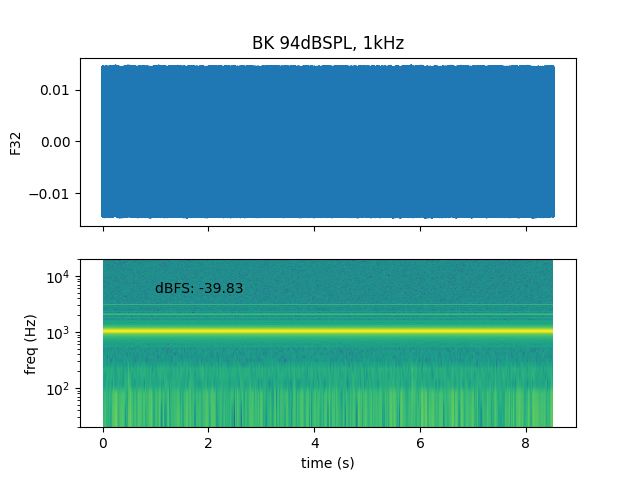

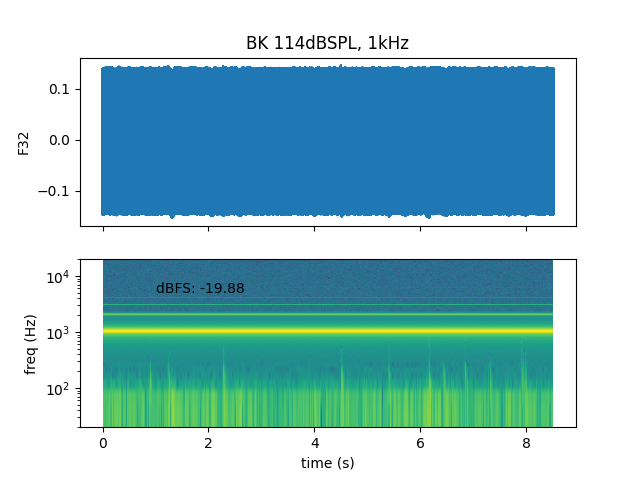

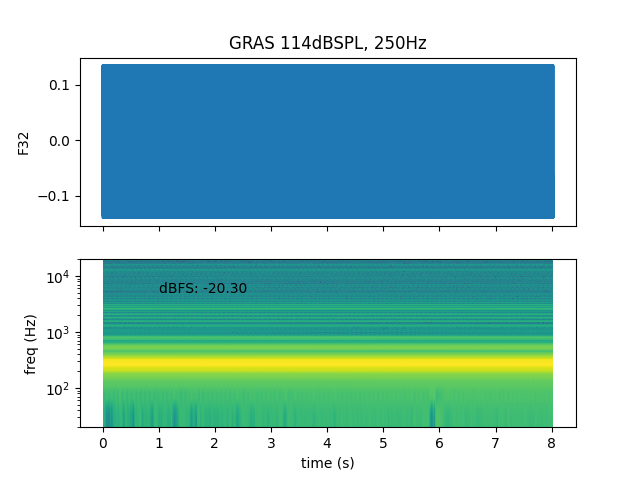

In [41]:
for idx, tmp_data in enumerate(cal_data):
    # plot
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    ax1.plot(tmp_data.time_s, tmp_data.wav_f32)
    ax1.set_ylabel('F32')
    ax1.set_title(tmp_data.trial_name)

    Pxx, freqs, bins, im = ax2.specgram(tmp_data.wav_f32, NFFT=2048, Fs=tmp_data.sample_rate_hz, scale='dB')
    ax2.text( 1, 5000, "dBFS: " + "{:.2f}".format(tmp_data.rms_dBFS) )

    ax2.set_ylim(20, 20000)
    ax2.set_yscale('log')
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('freq (Hz)')

    plt.show()


In [64]:
for idx, tmp_data in enumerate(cal_data):
    print(cal_data[idx].trial_name)

BK 94dBSPL, 1kHz
BK 114dBSPL, 1kHz
GRAS 114dBSPL, 250Hz
